In [1]:
import pandas as pd
import json
import os
from IPython.display import display
import sys
sys.path.append("../traffic_generator")
sys.path.append("../interference_injection")
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

In [2]:
# --- NEW: helper to prettify legend labels ---
def pretty_label(test_id: str) -> str:
    tid = test_id.lower()
    if "marla" in tid:
        return "Marla"
    if "naive" in tid:
        return "Naive"
    return test_id

In [3]:
import pandas as pd
import json
import os

def load_and_merge_test_data(test_ids, max_time_diff="30s"):
    merged_dfs = []

    for test_id in test_ids:
        print(f"\n===== Test ID: {test_id} =====")
        
        # === Determine source folder for JSONL based on test ID ===
        if "naive" in test_id:
            log_folder = "./naive_logs"
        elif "marla" in test_id:
            log_folder = "./marla_logs"
        else:
            print(f"Unknown strategy in test_id: {test_id}. Skipping.")
            continue
        
        # === Paths ===
        csv_path = f"./traffic_generator_csvs/performance_{test_id}.csv"
        jsonl_path = os.path.join(log_folder, f"{test_id}.jsonl")
        
        # === Load CSV ===
        if not os.path.exists(csv_path):
            print(f"CSV not found for {test_id}: {csv_path}")
            continue
        
        df_perf = pd.read_csv(csv_path)
        df_perf["Time"] = pd.to_datetime(df_perf["Time"])
        
        # === Load JSONL ===
        if os.path.exists(jsonl_path):
            with open(jsonl_path, "r") as f:
                records = [json.loads(line.strip()) for line in f if line.strip()]
            df_dist = pd.DataFrame(records)
            df_dist["timestamp"] = pd.to_datetime(df_dist["timestamp"])

            # === Merge by nearest timestamp ===
            df_perf_sorted = df_perf.sort_values("Time").copy()
            df_dist_sorted = df_dist.sort_values("timestamp").copy()

            merged_df = pd.merge_asof(
                df_perf_sorted,
                df_dist_sorted,
                left_on="Time",
                right_on="timestamp",
                direction="nearest",
                tolerance=pd.Timedelta(max_time_diff) if max_time_diff else None
            )

            merged_dfs.append(merged_df)
            print("✔ Merged with replica distribution data.")
        else:
            print("⚠ No distribution data found. Returning only performance metrics.")
            merged_dfs.append(df_perf)

    return merged_dfs


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_metric_by_minute(merged_dfs, test_ids, metric="P99_Latency", max_display_value=20, minute_cap=30):
    """
    Plots the selected metric using the 'Minute' column as x-axis (left, larger subplot),
    and a compact average-bar plot (right, smaller subplot with exactly 2 bars based on first two test_ids).
    """
    # ---- compute time series + averages ----
    averages = {}
    cleaned_series = {}  # store cleaned dfs per test for left plot

    for df, test_id in zip(merged_dfs, test_ids):
        if df.empty or metric not in df.columns or 'Minute' not in df.columns:
            print(f"Skipping {test_id}: missing 'Minute' or metric column.")
            continue

        d = df.copy()
        d["Minute"] = pd.to_numeric(d["Minute"], errors='coerce')
        d[metric] = pd.to_numeric(d[metric], errors='coerce')

        d = d[(d[metric] < max_display_value) & (d["Minute"] <= minute_cap)]
        if d.empty:
            print(f"Skipping {test_id}: no data after filtering.")
            continue

        cleaned_series[test_id] = d
        averages[test_id] = d[metric].mean()

    # Nothing valid to plot
    if not cleaned_series:
        print("No valid data to plot.")
        return

    # ---- figure & layout ----
    plt.rcParams['font.family'] = 'DejaVu Serif'
    fig, (ax_left, ax_right) = plt.subplots(
        1, 2, figsize=(12, 5), gridspec_kw={"width_ratios": [3, 1]}
    )

    # ---- left subplot: P99 over time ----
    for test_id, d in cleaned_series.items():
        ax_left.plot(
            d["Minute"], d[metric],
            marker='o', linewidth=2, label=pretty_label(test_id)
        )

    ax_left.set_title(f"{metric.replace('_', ' ')} Over 30 Minutes")
    ax_left.set_xlabel("Minute")
    ax_left.set_ylabel(metric.replace("_", " ") + " (ms)")
    ax_left.grid(True, alpha=0.3)
    ax_left.legend()
    ax_left.set_xticks(range(0, minute_cap + 1, 2))

    # ---- right subplot: average bar plot (2 bars) ----
    # pick exactly two bars: first two from test_ids that exist in averages
    selected = [tid for tid in test_ids if tid in averages][:2]
    if len(selected) < 2 and len(averages) >= 2:
        # fallback: take any two from averages
        selected = list(averages.keys())[:2]

    if len(selected) == 2:
        vals = [averages[selected[0]], averages[selected[1]]]
        labels = [pretty_label(selected[0]), pretty_label(selected[1])]
        bars = ax_right.bar(labels, vals)
        ax_right.set_title(f"Avg {metric.replace('_', ' ')}")
        ax_right.set_ylabel("ms")
        ax_right.set_ylim(0, max(vals) * 1.15 if vals else 1)

        # annotate bars with value
        for rect, v in zip(bars, vals):
            ax_right.annotate(f"{v:.2f}",
                              xy=(rect.get_x() + rect.get_width() / 2, rect.get_height()),
                              xytext=(0, 5),
                              textcoords="offset points",
                              ha='center', va='bottom', fontsize=9)
    else:
        # if fewer than 2, show whatever is available (still compact)
        labels = list(averages.keys())
        vals = [averages[k] for k in labels]
        bars = ax_right.bar(labels, vals)
        ax_right.set_title(f"Avg {metric.replace('_', ' ')}")
        ax_right.set_ylabel("ms")
        for rect, v in zip(bars, vals):
            ax_right.annotate(f"{v:.2f}",
                              xy=(rect.get_x() + rect.get_width() / 2, rect.get_height()),
                              xytext=(0, 5),
                              textcoords="offset points",
                              ha='center', va='bottom', fontsize=9)

    # tidy right subplot
    ax_right.grid(True, axis='y', alpha=0.2)

    plt.tight_layout()
    plt.show()

    # Optional: print the full averages table and % differences, as before
    if averages:
        avg_df = pd.DataFrame([
            {"Test ID": k, f"Avg {metric} (ms)": f"{v:.3f}"} for k, v in averages.items()
        ]).sort_values(by=f"Avg {metric} (ms)")
        print("\n=== AVERAGE METRIC TABLE ===")
        display(avg_df)

    if len(averages) >= 2:
        diffs = []
        labels = list(averages.keys())
        for i in range(len(labels)):
            for j in range(i + 1, len(labels)):
                a, b = labels[i], labels[j]
                v1, v2 = averages[a], averages[b]
                percent_diff = abs(v1 - v2) / ((v1 + v2) / 2) * 100
                diffs.append({"Comparison": f"{a} vs {b}", "% Difference": f"{percent_diff:.2f}%"})
        diff_df = pd.DataFrame(diffs)
        print("\n=== % DIFFERENCES BETWEEN AVERAGES ===")
        display(diff_df)


In [5]:
def plot_replica_distribution_combined(merged_dfs, test_ids, minute_cap=30):
    """
    Plots replica distribution over time for all test IDs in one figure.
    One subplot per node (minikube, minikube-m02), with multiple lines (one per controller).

    Args:
        merged_dfs (list of pd.DataFrame): List of merged DataFrames.
        test_ids (list of str): Matching test IDs.
        minute_cap (int): Maximum minute value for the x-axis.
    """
    plt.rcParams['font.family'] = 'DejaVu Serif'
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=True)

    for df, test_id in zip(merged_dfs, test_ids):
        if df.empty or "replica_distribution" not in df.columns or "Minute" not in df.columns:
            print(f"Skipping {test_id}: required columns missing.")
            continue

        df = df.copy()
        df["Minute"] = pd.to_numeric(df["Minute"], errors="coerce")
        df = df[df["Minute"] <= minute_cap]

        # Extract replica counts for both nodes from the dict column
        df["replicas_minikube"] = df["replica_distribution"].apply(
            lambda d: d.get("minikube", 0) if isinstance(d, dict) else 0
        )
        df["replicas_minikube_m02"] = df["replica_distribution"].apply(
            lambda d: d.get("minikube-m02", 0) if isinstance(d, dict) else 0
        )

        # Plot for node: minikube
        axes[0].plot(df["Minute"], df["replicas_minikube"],
                    marker='o', linewidth=2, label=pretty_label(test_id))

        # Plot for node: minikube-m02
        axes[1].plot(df["Minute"], df["replicas_minikube_m02"],
                     marker='o', linewidth=2, label=pretty_label(test_id))

    # === Formatting both subplots ===
    axes[0].set_title("Node1")
    axes[0].set_ylabel("Replicas")
    axes[0].yaxis.set_major_locator(MaxNLocator(integer=True))
    axes[0].grid(True)
    axes[0].legend()

    axes[1].set_title("Node2")
    axes[1].set_ylabel("Replicas")
    axes[1].set_xlabel("Minute")
    axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))
    axes[1].grid(True)
    axes[1].legend()
    for ax in axes:
        ax.set_xticks(range(0, minute_cap + 1, 2))

    fig.suptitle("Replica Distribution Over Time", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



In [6]:
def plot_nginx_capacity_share_cluster(
    merged_dfs,
    test_ids,
    minute_cap=30,
    per_pod_capacity_units=0.5,    # 0.5 "units" per pod (e.g., 0.5 cores or 0.5 GiB)
    node_capacity_units=3.0,       # 3 "units" per node (e.g., 3 cores or 3 GiB)
    num_nodes=2                    # cluster size
):
    """
    Plots the average fraction of total cluster *requested capacity* 
    allocated to Nginx pods for each experiment (single value per test_id).
    """
    import matplotlib.pyplot as plt
    import pandas as pd

    cluster_capacity = node_capacity_units * num_nodes
    plt.rcParams['font.family'] = 'DejaVu Serif'
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))

    averages = {}
    for df, test_id in zip(merged_dfs, test_ids):
        if df.empty or "replica_distribution" not in df.columns or "Minute" not in df.columns:
            print(f"Skipping {test_id}: required columns missing.")
            continue

        d = df.copy()
        d["Minute"] = pd.to_numeric(d["Minute"], errors="coerce")
        d = d[d["Minute"] <= minute_cap]

        def _sum_replicas(x):
            if isinstance(x, dict):
                return sum(int(v) for v in x.values())
            return 0

        d["total_replicas"] = d["replica_distribution"].apply(_sum_replicas)
        d["capacity_share_pct"] = (
            d["total_replicas"] * per_pod_capacity_units
        ) / cluster_capacity * 100.0

        avg_pct = d["capacity_share_pct"].mean()
        averages[test_id] = avg_pct

    if not averages:
        print("No valid data to compute averages.")
        return

    # Plot as bar chart
    ax.bar(range(len(averages)), list(averages.values()), tick_label=list(averages.keys()))
    ax.set_title("Average Cluster Capacity Share per Experiment")
    ax.set_ylabel("Avg % of Cluster Capacity (requests)")
    ax.set_ylim(0, 100)
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

    return averages


In [7]:
def summarize_experiment_metrics(
    merged_dfs,
    test_ids,
    minute_cap=30,
    per_pod_capacity_units=0.5,   # capacity units per pod (e.g. 0.5 cores)
    node_capacity_units=3.0,      # per-node capacity (e.g. 3 cores)
    num_nodes=2                   # number of nodes
):
    """
    Computes summary metrics for each experiment:
    - Global P99 (99th percentile of all samples)
    - Avg Cluster Usage (% of cluster capacity requested)
    - Peak Cluster Usage (% of cluster capacity requested)
    - Avg Replicas (average number of replicas across minutes)

    Returns a DataFrame with one row per test_id.
    """
    import pandas as pd
    import numpy as np

    cluster_capacity = node_capacity_units * num_nodes
    results = []

    for df, test_id in zip(merged_dfs, test_ids):
        if df.empty or "replica_distribution" not in df.columns or "Minute" not in df.columns or "P99_Latency" not in df.columns:
            print(f"Skipping {test_id}: required columns missing.")
            continue

        d = df.copy()
        d["Minute"] = pd.to_numeric(d["Minute"], errors="coerce")
        d["P99_Latency"] = pd.to_numeric(d["P99_Latency"], errors="coerce")
        d = d[d["Minute"] <= minute_cap]

        if d.empty:
            print(f"Skipping {test_id}: no rows after filtering by minute_cap.")
            continue

        # total replicas per minute
        def _sum_replicas(x):
            if isinstance(x, dict):
                return sum(int(v) for v in x.values())
            return 0

        d["total_replicas"] = d["replica_distribution"].apply(_sum_replicas)

        # capacity share
        d["capacity_share_pct"] = (
            d["total_replicas"] * per_pod_capacity_units / cluster_capacity * 100.0
        )

        # metrics
        global_p99 = np.nanpercentile(d["P99_Latency"].dropna(), 99)
        avg_capacity = d["capacity_share_pct"].mean()
        peak_capacity = d["capacity_share_pct"].max()
        avg_replicas = d["total_replicas"].mean()

        results.append({
            "Test ID": test_id,
            "Global P99 (ms)": round(global_p99, 3),
            "Avg Cluster Usage (%)": round(avg_capacity, 2),
            "Peak Cluster Usage (%)": round(peak_capacity, 2),
            "Avg Replicas": round(avg_replicas, 2)
        })

    if not results:
        print("No valid results to summarize.")
        return None

    summary_df = pd.DataFrame(results)
    display(summary_df)
    return summary_df


In [8]:
from config import RPS_30MIN_GRADUAL_WIDE

def plot_rps_schedule(rps_schedule, title="Traffic Load: RPS per Minute"):
    plt.rcParams['font.family'] = 'DejaVu Serif'
    plt.figure(figsize=(12, 4))
    plt.plot(range(len(rps_schedule)), rps_schedule, marker='o')
    plt.xlabel("Minute")
    plt.ylabel("RPS")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Traffic Load

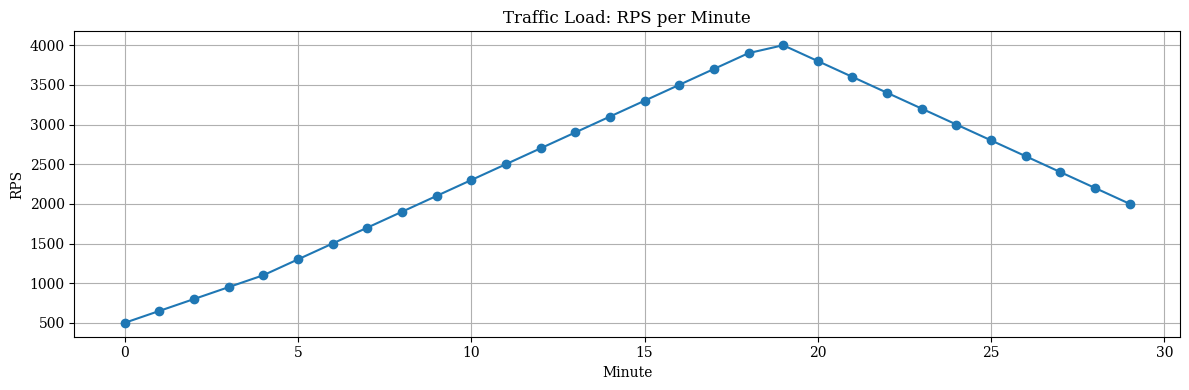

In [8]:
# Example usage
plot_rps_schedule(RPS_30MIN_GRADUAL_WIDE)

## CPU Interference


===== Test ID: cpu2_naive_v10 =====
✔ Merged with replica distribution data.

===== Test ID: cpu2_marla_v21 =====
✔ Merged with replica distribution data.


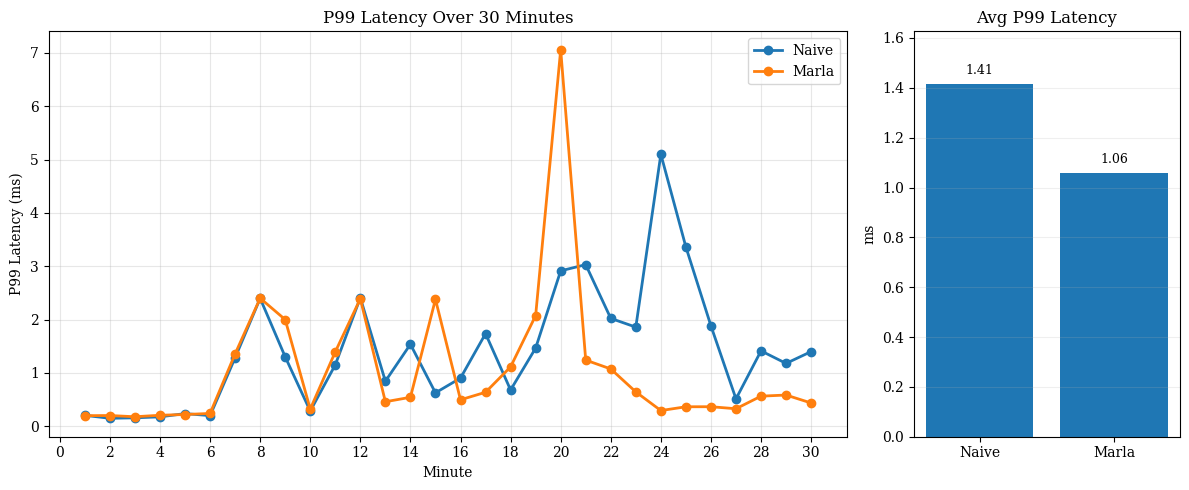


=== AVERAGE METRIC TABLE ===


,Test ID,Avg P99_Latency (ms)
1,cpu2_marla_v21,1.060
0,cpu2_naive_v10,1.415



=== % DIFFERENCES BETWEEN AVERAGES ===


,Comparison,% Difference
0,cpu2_naive_v10 vs cpu2_marla_v21,28.69%


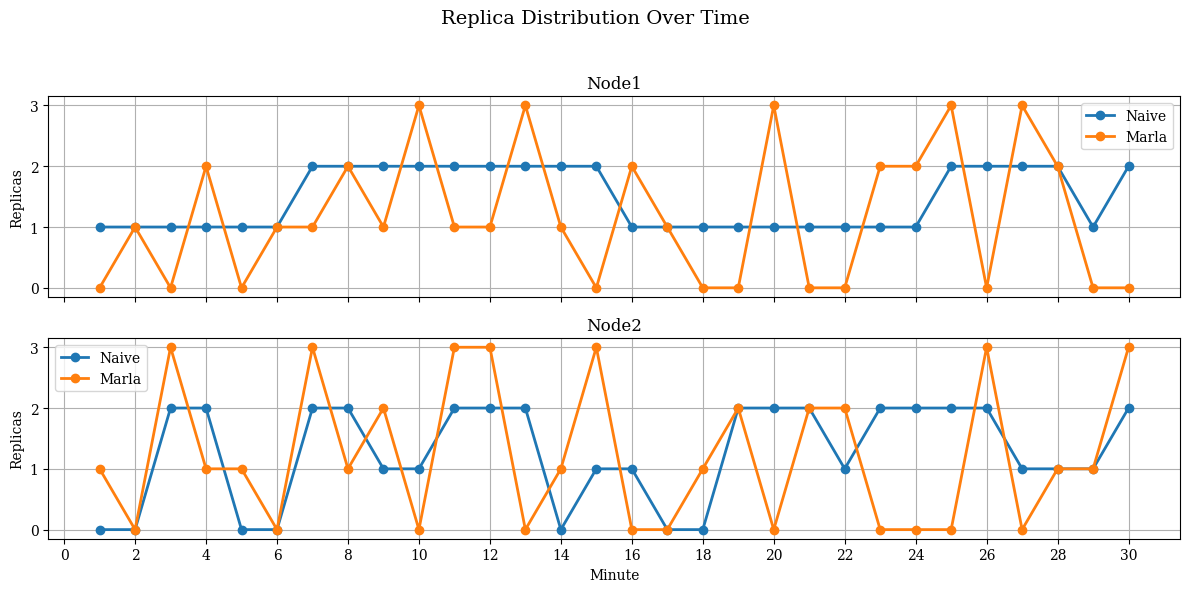

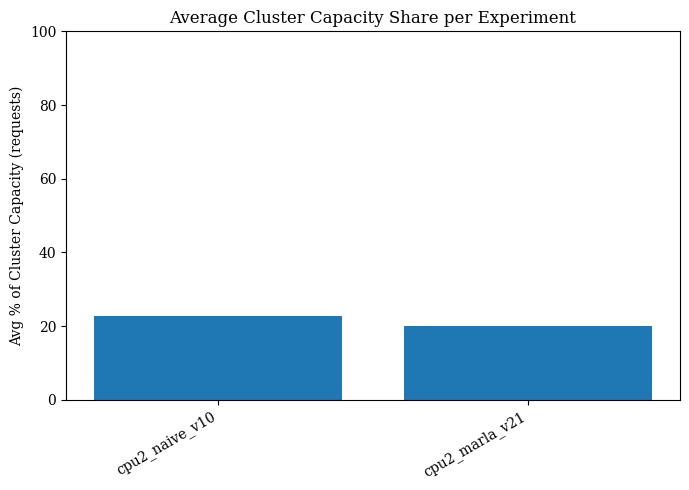

,Test ID,Global P99 (ms),Avg Cluster Usage (%),Peak Cluster Usage (%),Avg Replicas
0,cpu2_naive_v10,4.595,22.78,33.33,2.73
1,cpu2_marla_v21,5.707,20.00,33.33,2.40


In [18]:
names = ["cpu2_naive_v10", "cpu2_marla_v21"]
cpu01_dfs = load_and_merge_test_data(names)
plot_metric_by_minute(cpu01_dfs, names, metric="P99_Latency", max_display_value=20)
plot_replica_distribution_combined(cpu01_dfs, names, minute_cap=30)
#plot_total_replica_usage(cpu01_dfs, names, minute_cap=30)
plot_nginx_capacity_share_cluster(cpu01_dfs, names, minute_cap=30)
summary_df = summarize_experiment_metrics(cpu01_dfs, names, minute_cap=30)

## L3 Interference


===== Test ID: l3_as1_naive_v101 =====
✔ Merged with replica distribution data.

===== Test ID: l3_as1_marla_v101 =====
✔ Merged with replica distribution data.


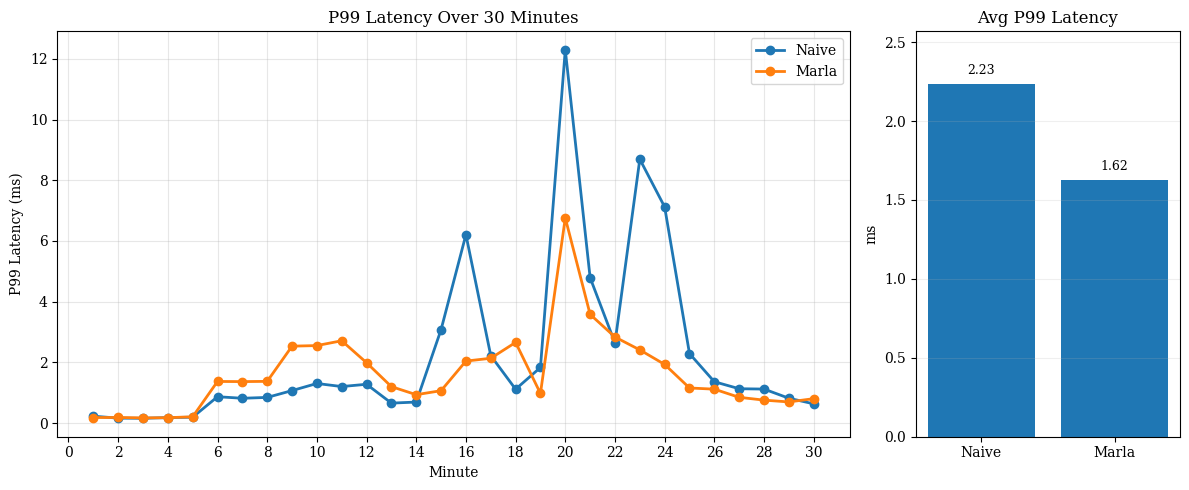


=== AVERAGE METRIC TABLE ===


,Test ID,Avg P99_Latency (ms)
1,l3_as1_marla_v101,1.624
0,l3_as1_naive_v101,2.234



=== % DIFFERENCES BETWEEN AVERAGES ===


,Comparison,% Difference
0,l3_as1_naive_v101 vs l3_as1_marla_v101,31.59%


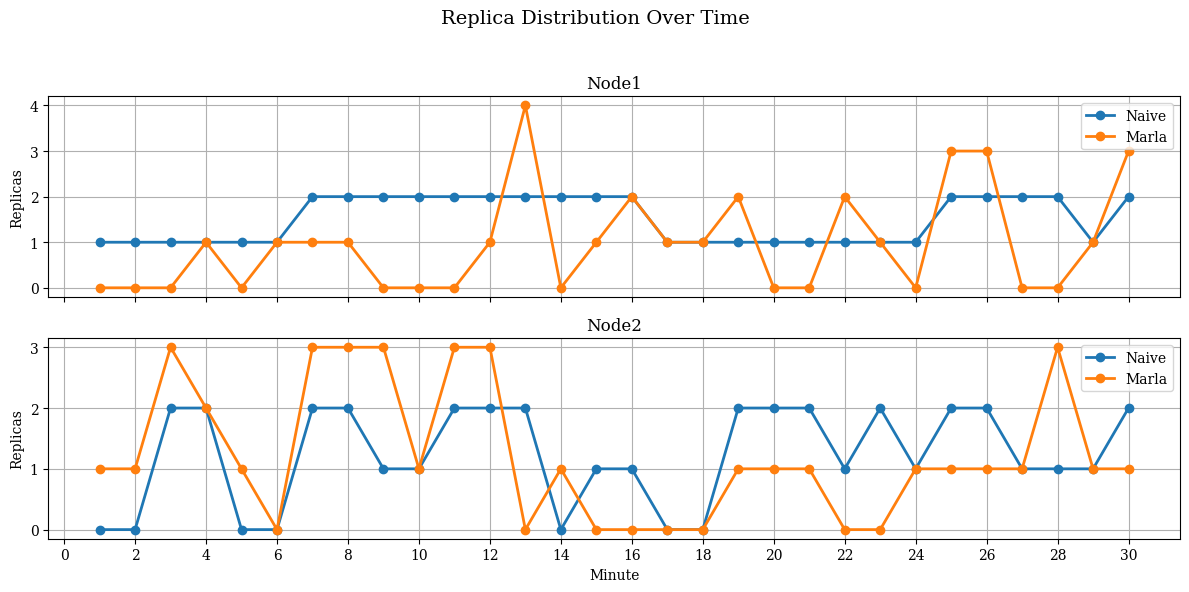

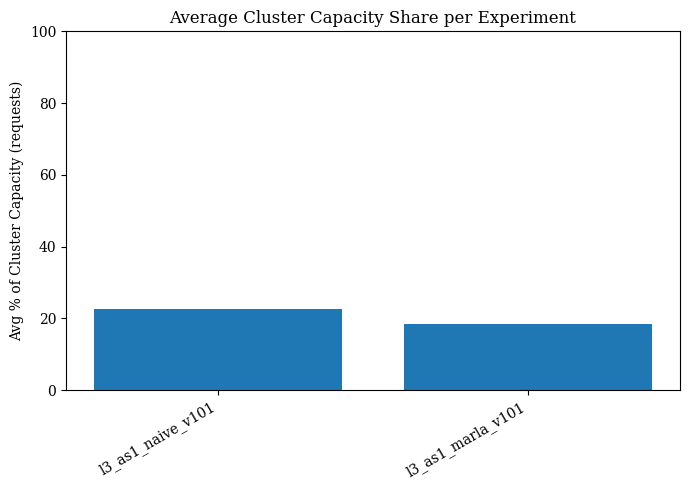

,Test ID,Global P99 (ms),Avg Cluster Usage (%),Peak Cluster Usage (%),Avg Replicas
0,l3_as1_naive_v101,11.254,22.78,33.33,2.73
1,l3_as1_marla_v101,5.837,18.33,33.33,2.20


In [19]:
names = ["l3_as1_naive_v101", "l3_as1_marla_v101"]
l3_v01_dfs = load_and_merge_test_data(names)
plot_metric_by_minute(l3_v01_dfs, names, metric="P99_Latency", max_display_value=20)
plot_replica_distribution_combined(l3_v01_dfs, names, minute_cap=30)
plot_nginx_capacity_share_cluster(l3_v01_dfs, names, minute_cap=30)
summary_df = summarize_experiment_metrics(l3_v01_dfs, names, minute_cap=30)

## MemBw Interference


===== Test ID: membw4_naive_v110 =====
✔ Merged with replica distribution data.

===== Test ID: membw4_marla_v110 =====
✔ Merged with replica distribution data.


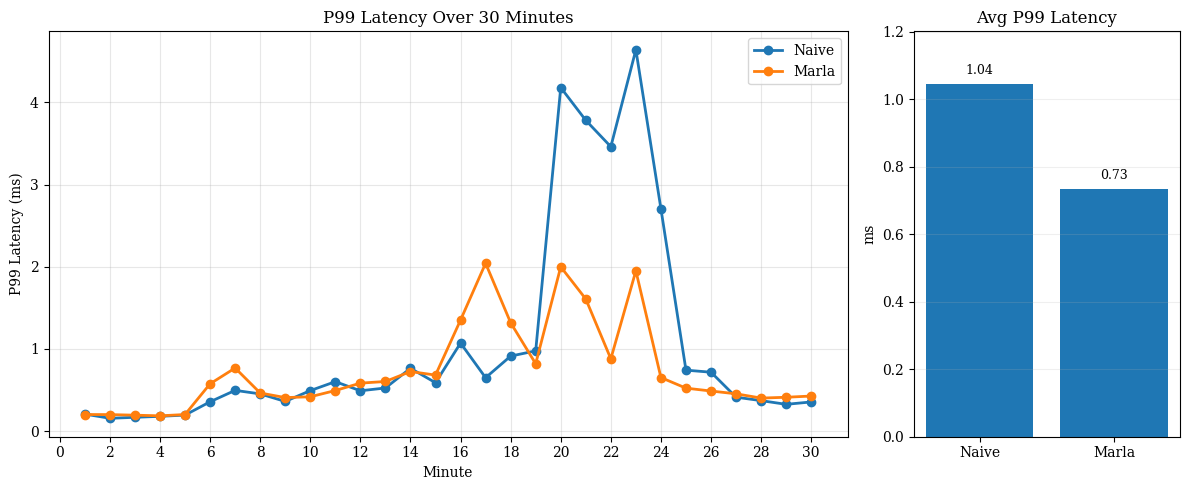


=== AVERAGE METRIC TABLE ===


,Test ID,Avg P99_Latency (ms)
1,membw4_marla_v110,0.734
0,membw4_naive_v110,1.044



=== % DIFFERENCES BETWEEN AVERAGES ===


,Comparison,% Difference
0,membw4_naive_v110 vs membw4_marla_v110,34.92%


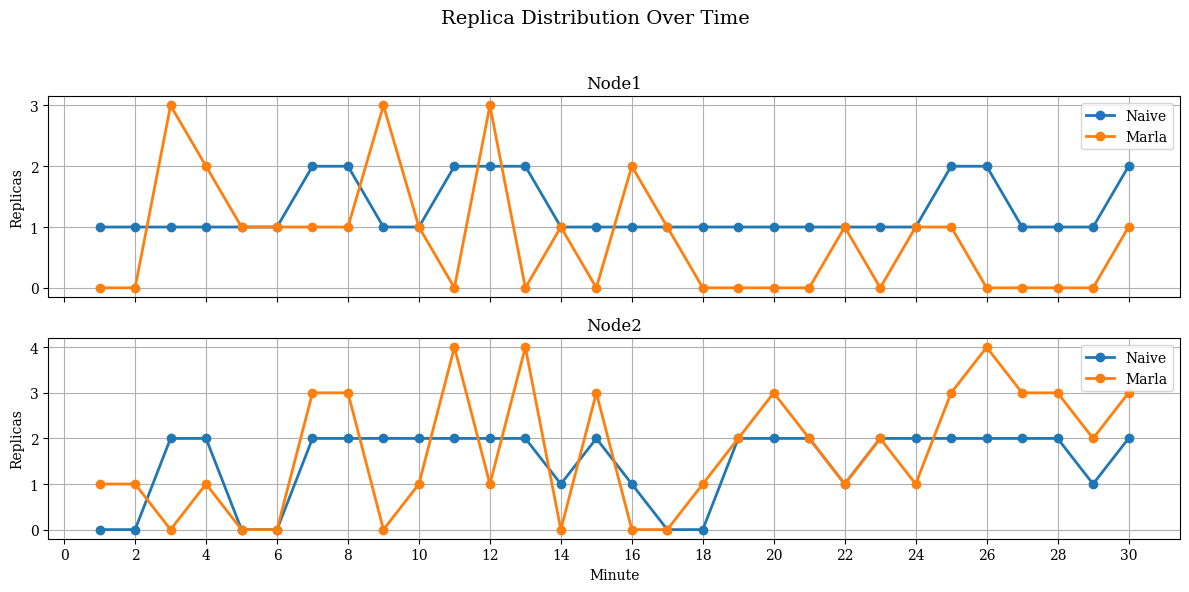

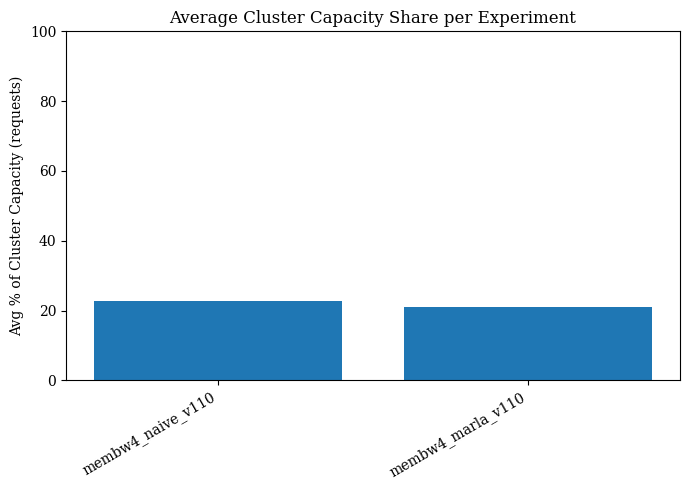

,Test ID,Global P99 (ms),Avg Cluster Usage (%),Peak Cluster Usage (%),Avg Replicas
0,membw4_naive_v110,4.508,22.78,33.33,2.73
1,membw4_marla_v110,2.030,21.11,33.33,2.53


In [20]:
names = ["membw4_naive_v110", "membw4_marla_v110"]
membw_v01_dfs = load_and_merge_test_data(names)
plot_metric_by_minute(membw_v01_dfs,names, metric="P99_Latency", max_display_value=20)
plot_replica_distribution_combined(membw_v01_dfs, names, minute_cap=30)
plot_nginx_capacity_share_cluster(membw_v01_dfs, names, minute_cap=30)
summary_df = summarize_experiment_metrics(membw_v01_dfs, names, minute_cap=30)

## MIXED Interference


===== Test ID: mixed_as1_naive_v102 =====
✔ Merged with replica distribution data.

===== Test ID: mixed_as1_marla_v105 =====
✔ Merged with replica distribution data.


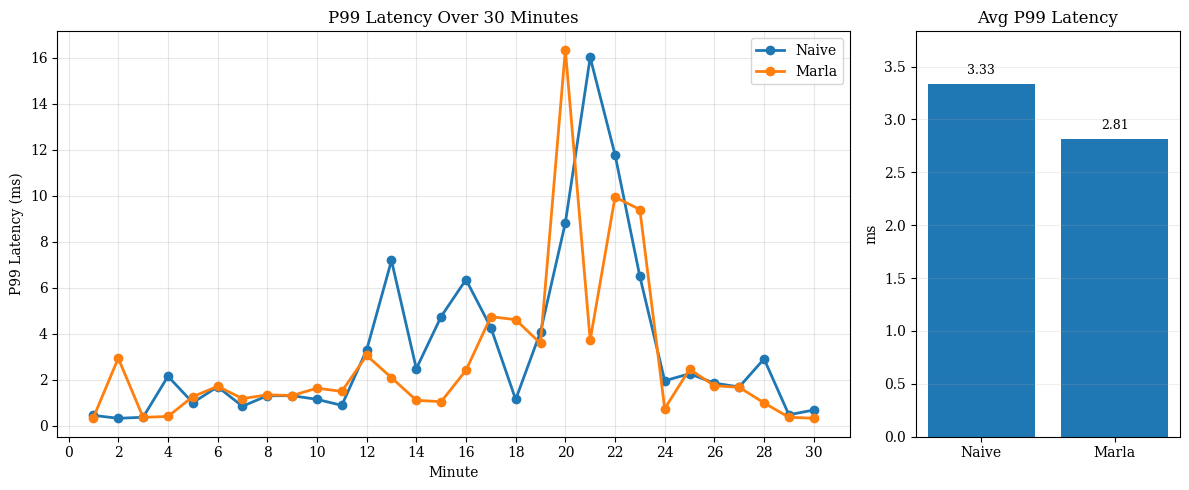


=== AVERAGE METRIC TABLE ===


,Test ID,Avg P99_Latency (ms)
1,mixed_as1_marla_v105,2.812
0,mixed_as1_naive_v102,3.333



=== % DIFFERENCES BETWEEN AVERAGES ===


,Comparison,% Difference
0,mixed_as1_naive_v102 vs mixed_as1_marla_v105,16.95%


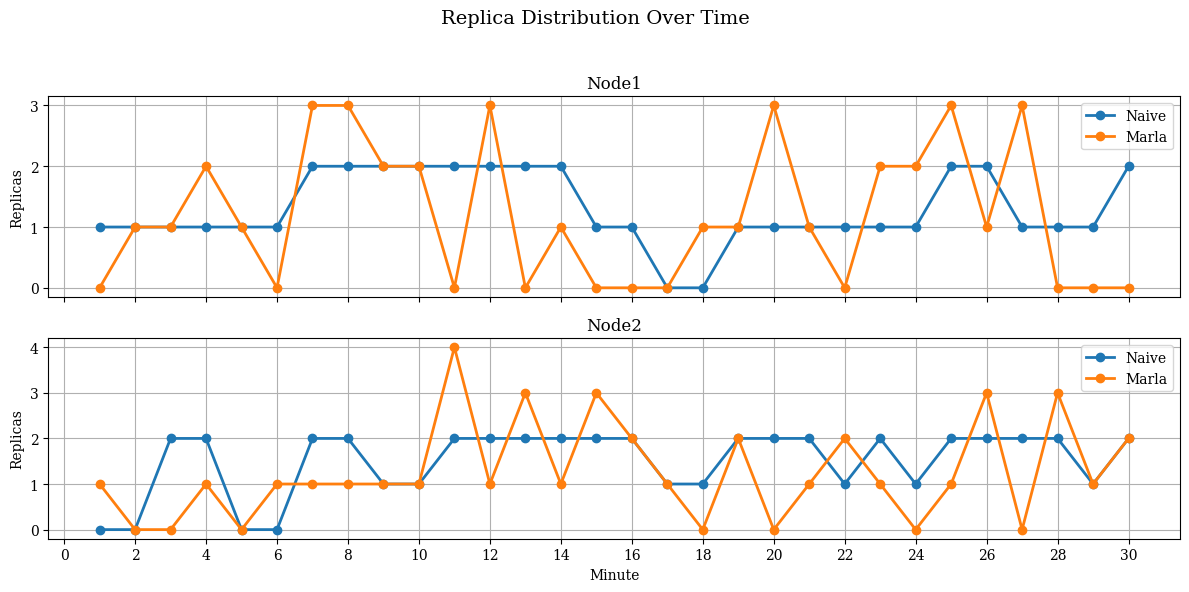

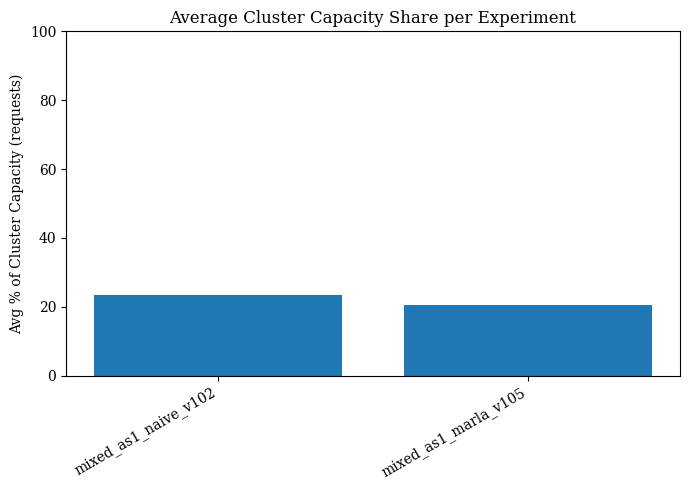

,Test ID,Global P99 (ms),Avg Cluster Usage (%),Peak Cluster Usage (%),Avg Replicas
0,mixed_as1_naive_v102,14.795,23.33,33.33,2.80
1,mixed_as1_marla_v105,14.496,20.56,33.33,2.47


In [28]:
names = ["mixed_as1_naive_v102", "mixed_as1_marla_v105"]
mixed_v01_dfs = load_and_merge_test_data(names)
plot_metric_by_minute(mixed_v01_dfs, names, metric="P99_Latency", max_display_value=20)
plot_replica_distribution_combined(mixed_v01_dfs, names, minute_cap=30)
plot_nginx_capacity_share_cluster(mixed_v01_dfs, names, minute_cap=30)
summary_df = summarize_experiment_metrics(mixed_v01_dfs, names, minute_cap=30)